In [1]:
# not included in requirements.txt:

# !pip install pandas
# !pip install scipy
# !pip install matplotlib
# !pip install dataframe_image

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dataframe_image as dfi

from math import e, pi

from matplotlib import rcParams
from scipy.optimize import minimize_scalar

from methods.base import Minimizer
from methods.broyden import Broyden
from methods.dfp import DFP
from methods.bfgs import BFGS
from methods.linesearch import backtracking

rcParams.update({'figure.autolayout': True})
%matplotlib inline

# Objectives
**Source**:
Momin Jamil and Xin-She Yang, A literature survey of benchmark functions for
global optimization problems, Int. Journal of Mathematical Modelling and
Numerical Optimisation, Vol. 4, No. 2, pp. 150–194 (2013).

### Rosenbrock Function
Continuous, Differentiable, Non-Separable, Scalable, Unimodal

**Function (2d)**:
$f(x, y) = b*(y - x^2)^2+ (a - x)^2$

**Minimum**:
$x^* = (a, a^2), f(x*) = 0$

In [11]:
def rosenbrock(x):
    return np.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0, axis=0)

def rosenbrock_grad(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = (200 * (xm - xm_m1**2) -
                 400 * (xm_p1 - xm**2) * xm - 2 * (1 - xm))
    der[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    der[-1] = 200 * (x[-1] - x[-2]**2)
    return der

def rosenbrock_hess(x):
    H = np.diag(-400 * x[:-1], 1) - np.diag(400 * x[:-1], -1)
    diagonal = np.zeros(len(x), dtype=x.dtype)
    diagonal[0] = 1200 * x[0]**2 - 400 * x[1] + 2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200 * x[1:-1]**2 - 400 * x[2:]
    H = H + np.diag(diagonal)
    return H

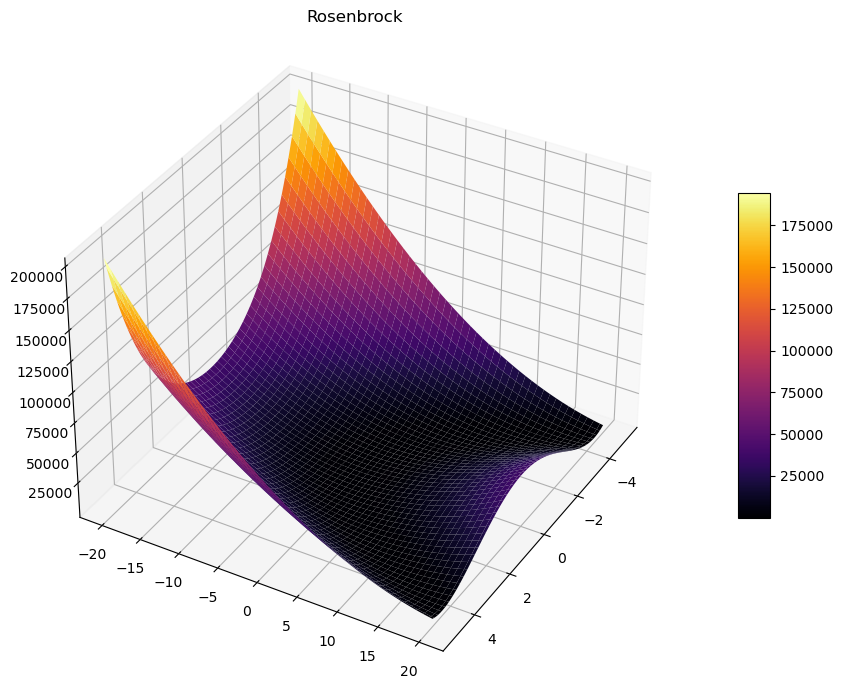

In [12]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-20, 20, 100)

x, y = np.meshgrid(x, y)
z = rosenbrock(np.array((x, y)))

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection='3d')
ax.view_init(elev=35., azim=30)
ax.set_title('Rosenbrock')

surf = ax.plot_surface(x, y, z, cmap='inferno')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

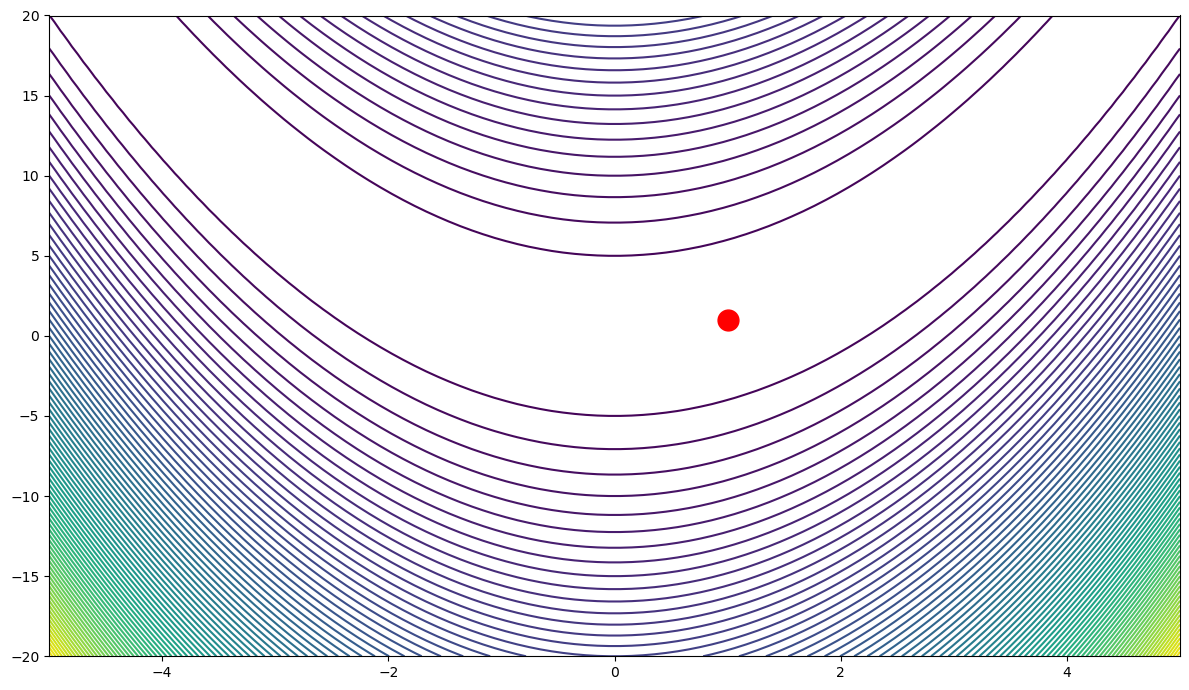

In [13]:
fig = plt.figure(figsize=(12, 7))
plt.contour(x, y, z, 100)
plt.plot(1, 1, marker='o', markersize=15, color ='r')
plt.show()

### Himmelblau Function
Continuous, Differentiable, Non-Separable, Non-Scalable, Multimodal

**Function (2d)**:
$f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$

**Minimum**:
$x^* = (3, 2), f(x*) = 0$

In [14]:
def himmelblau(x):
    x, y = x
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2


def himmelblau_grad(x):
    x, y = x
    return np.array([
        4 * x * (x**2 + y - 11) + 2 * (x + y**2 - 7),
        2 * (x**2 + y - 11) + 4 * y * (x + y**2 - 7)
    ])


def himmelblau_hess(x):
    x, y = x
    return np.array([
        [4 * (3 * (x ** 2) + y - 11) + 2, 4 * (x + y)],
        [4 * (x + y), 4 * (x + 3 * (y ** 2) - 7) + 2]
    ])

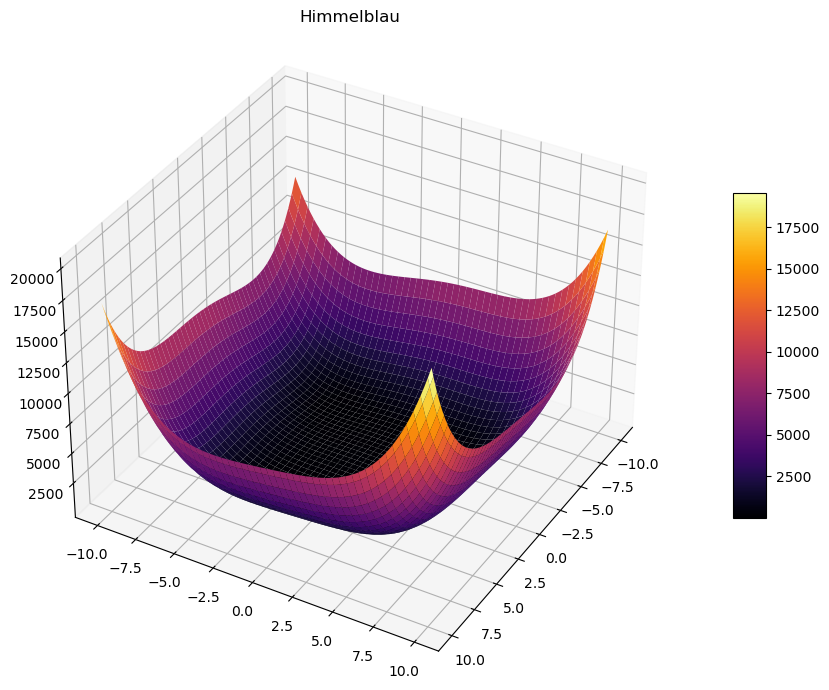

In [15]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

x, y = np.meshgrid(x, y)
z = himmelblau(np.array((x, y)))

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection='3d')
ax.view_init(elev=35., azim=30)
ax.set_title('Himmelblau')

surf = ax.plot_surface(x, y, z, cmap='inferno')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

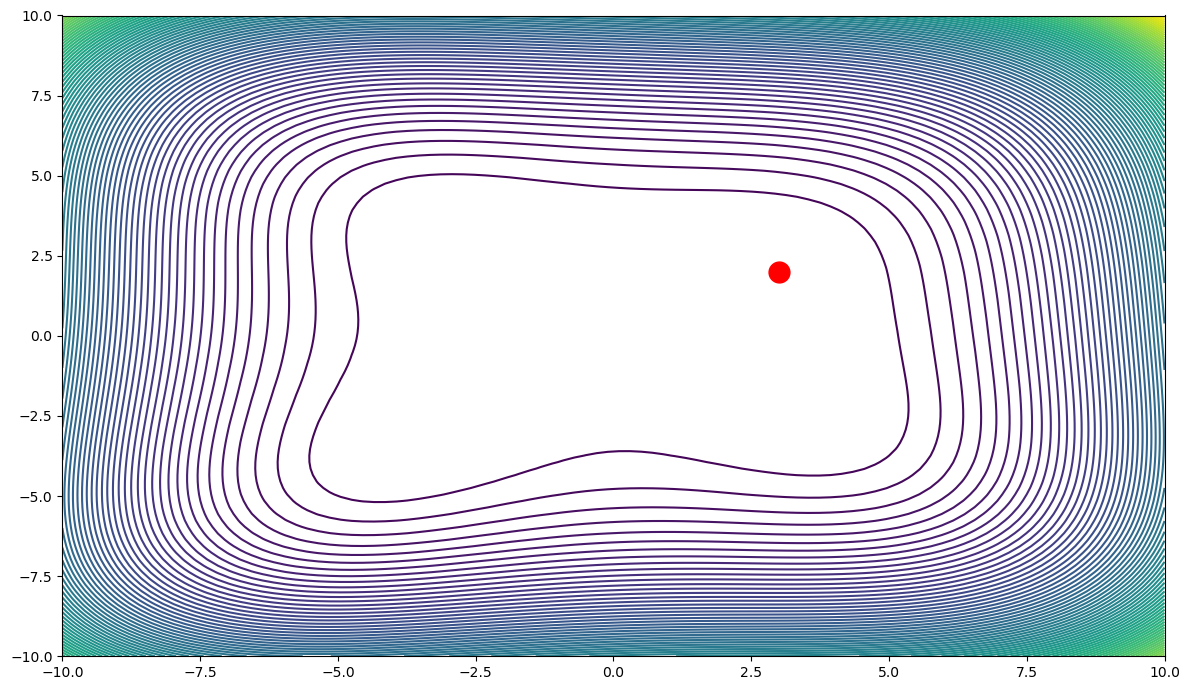

In [16]:
fig = plt.figure(figsize=(12, 7))
plt.contour(x, y, z, 100)
plt.plot(3, 2, marker='o', markersize=15, color ='r')
plt.show()

### Ackley 1 Function
Continuous, Differentiable, Non-separable, Scalable, Multimodal

**Function (2d)**:
$f(x, y) = -20exp(-0.2 * \sqrt{0.5(x^2 + y^2)}) - exp(0.5(cos(2 \pi x) + cos(2 \pi y))) + e + 20$

**Minimum**:
$x^* = (0, 0), f(x*) = 0$

In [17]:
def ackley(x):
    x, y = x
    return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - \
           np.exp(0.5 * (np.cos(2 * pi * x)+np.cos(2 * pi * y))) + e + 20


def ackley_grad(x):
    x, y = x

    a = (x** 2 + y**2) / 2
    b = (np.cos(2*pi*x) + np.cos(2*pi*y)) / 2

    def grad_(var):
        return 4*var * (np.exp(-0.2 ** np.sqrt(a)) / 2 * np.sqrt(a)) + (2 * pi * np.sin(2*pi*var) * np.exp(b) / 2)

    return np.array([
        grad_(x),
        grad_(y)
    ])

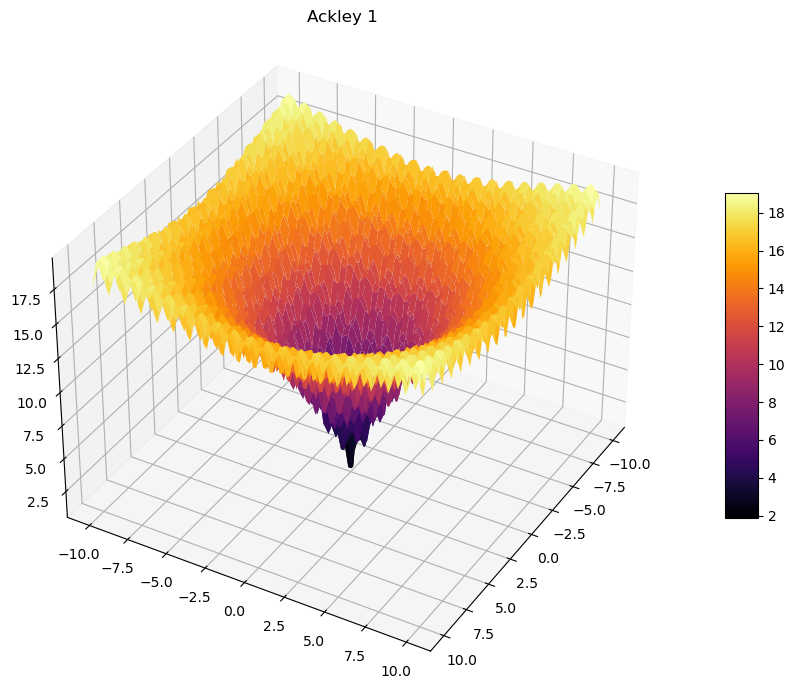

In [18]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

x, y = np.meshgrid(x, y)
z = ackley(np.array((x, y)))

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection='3d')
ax.view_init(elev=35., azim=30)
ax.set_title('Ackley 1')

surf = ax.plot_surface(x, y, z, cmap='inferno')
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

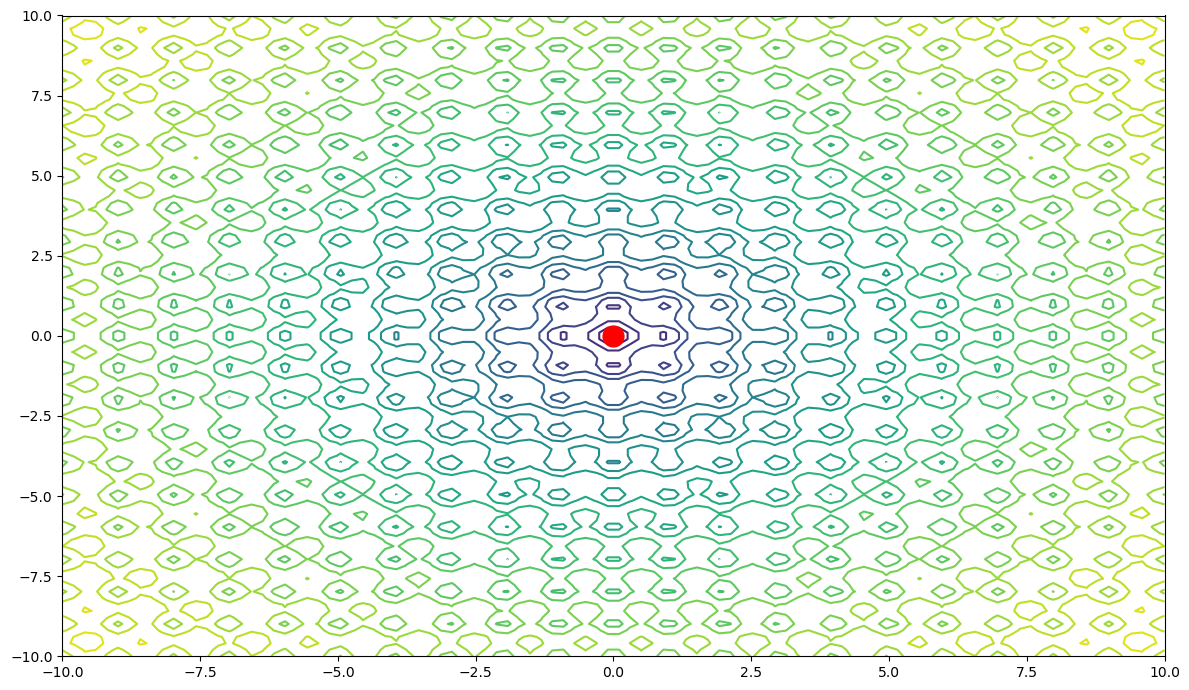

In [19]:
fig = plt.figure(figsize=(12, 7))
plt.contour(x, y, z, 20)
plt.plot(0, 0, marker='o', markersize=15, color ='r')
plt.show()

# Additional methods

Define the Gradient Descent and Newton optimizers to compare convergence with three-step iterative method.

In [4]:
import functools

from methods.base import MinimizeResult
from methods.gradient import finite_difference


# override optimizer method `__call__()` to change stop condition
# warning: this is for research purposes only and is not recommended for use under normal conditions
def custom_call(self, x, f, df, *args, eps = 1e-8, maxiter = 100, **kwargs):
    if df is None:
        df = functools.partial(finite_difference, func=f, type_='C')

    x = np.atleast_1d(x)
    x = x.astype(float)

    self.build(x.shape)

    xp = 0
    for i in range(maxiter):
        # if np.linalg.norm(df(x)) < eps:
        if np.linalg.norm(x - xp) < eps and i != 0:
            return MinimizeResult(x, success=True, nit=i+1)

        xp = x.copy()
        np.add(x, self.update(x, f, df, i, *args, **kwargs), out=x)

    return MinimizeResult(x, success=False, nit=maxiter)


Minimizer.__call__ = custom_call

In [7]:
class GradientDescent(Minimizer):

    def update(self, x, f, df, *args, **kwargs):
        search_direction = -df(x)
        alpha, *_ = backtracking(x, search_direction, f, df, *args, **kwargs)

        return alpha * search_direction


class Newton(Minimizer):

    def update(self, x, f, df, *args, ddf=None, **kwargs):
        return -np.linalg.inv(ddf(x)).dot(df(x))

# Three-step iterative method

Steps:
    1. Calculate the first approximation $u$
    2. Calculate secondary approximation $v$
    3. Calculate $x_{k+1}$ as $u - \beta (u - v)$, where $f(u - \beta (u - v)) = \min_{\beta} f(u - \beta (u - v))$


In [8]:
class ThreeStepIterative(Minimizer):

    def __init__(self, step_1: Minimizer, step_2: Minimizer):
        self.u_method = step_1
        self.v_method = step_2

        self.history = {'x': []}

    def update(self, x, f, df, i, *args, step_maxiter=1, options_1=None, options_2=None, record=False, **kwargs):
        if record:
            self.history['x'].append(x.copy())

        # `Callback` step_maxiter is used to make the dynamic parameter possible
        step_maxiter = step_maxiter(i)

        # step 1
        u_options = options_1 or {}
        u = self.u_method(x, f, df, maxiter=step_maxiter, **u_options).x

        # step 2
        v_options = options_2 or {}
        v = self.v_method(x, f, df, maxiter=step_maxiter, **v_options).x

        # step 3
        xlo = kwargs.pop('xlo', 0)
        xhi = kwargs.pop('xhi', 1)

        phi = lambda beta: f(u - beta * (u-v)).sum()
        beta = minimize_scalar(phi, *args, bracket=(xlo, xhi), **kwargs).x

        # see `Minimizer.__call__()` method implementation for details
        # x_{k+1} = x_{k} + (u - beta * (u-v)) - x_{k}, so x_{k+1} = u - beta * (u-v)
        return (u - beta * (u-v)) - x

# Benchmarks

In [9]:
minimize = ThreeStepIterative(step_1=DFP(), step_2=GradientDescent())

### Compare different values of the `step_maxiter` param for the Rosenbrock function

In [20]:
minimize(
    np.zeros(2),
    rosenbrock,
    None,
    maxiter=100,
    eps=1e-5,
    step_maxiter=lambda ic: 2,
    record=False,
    method='brent',
)

MinimizeResult(x=array([1.00000376, 1.00000748]), success=True, nit=13)

In [21]:
values = {}

for i in range(1, 11):
    min_ = minimize(
        np.zeros(2),
        rosenbrock,
        None,
        maxiter=100,
        eps=1e-5,
        step_maxiter=lambda ic: i,
        record=True,
        method='brent',
    )

    minimize.history['x'].append(min_.x)
    values[i] = (np.asarray(minimize.history['x']), min_.nit)
    minimize.history['x'] = []

In [ ]:
benchmark_table = {}

for i in range(1, 11):
    min_func = lambda imax: minimize(
        np.zeros(2),
        rosenbrock,
        None,
        maxiter=100,
        eps=1e-5,
        step_maxiter=lambda ic: imax,
        record=False,
        method='brent',
    )

    min_ = min_func(i)
    t = %timeit -r 5 -n 100 -o min_func(i)

    benchmark_table[i] = t

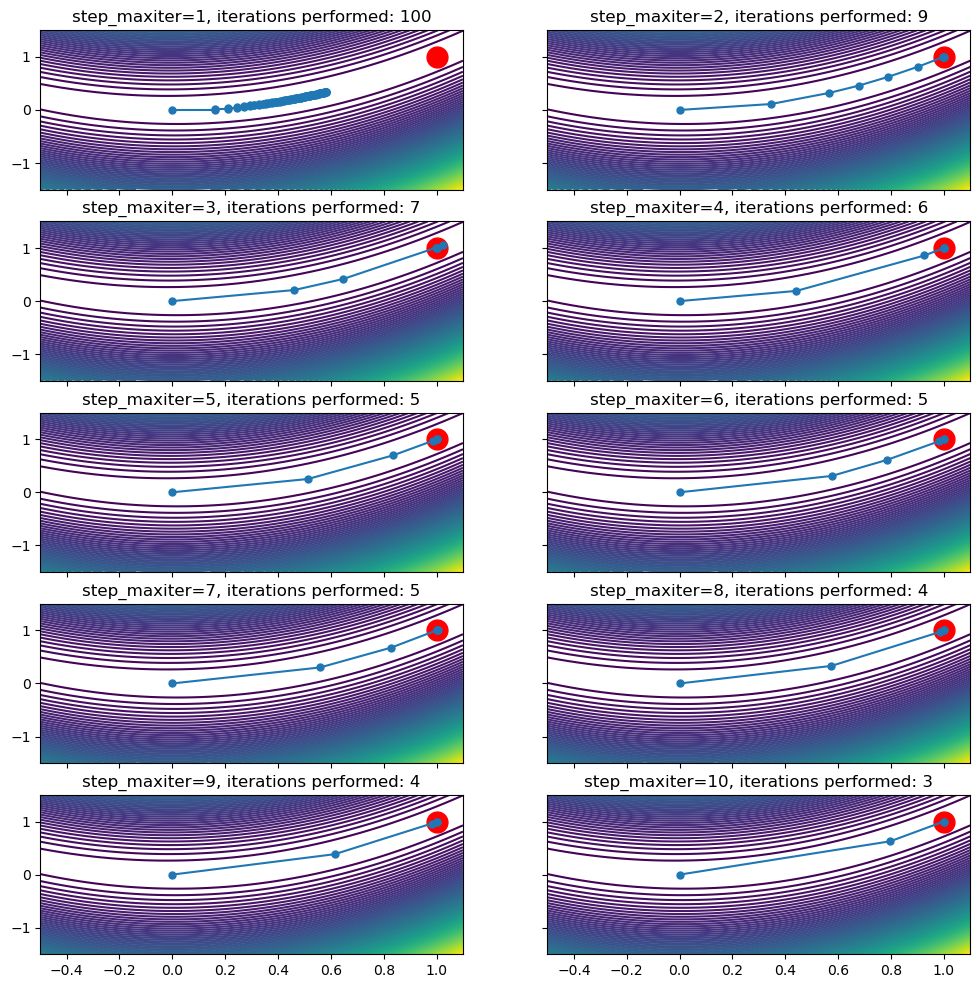

In [52]:
x = np.linspace(-0.5, 1.1, 100)
y = np.linspace(-1.5, 1.5, 100)

x, y = np.meshgrid(x, y)
z = rosenbrock(np.array((x, y)))

fig, axs = plt.subplots(5, 2, figsize=(12, 12), sharex=True, sharey=True)

k = 1
for i in range(5):
    for j in range(2):
        xy = values[k][0]

        axs[i, j].set_title(f"step_maxiter={k}, iterations performed: {values[k][1]}")
        axs[i, j].contour(x, y, z, 100)
        axs[i, j].plot(1, 1, marker='o', markersize=15, color ='r')

        axs[i, j].plot(xy[:, 0], xy[:, 1], marker='o', markersize=5)
        k += 1

plt.show()

In [167]:
df = pd.DataFrame.from_dict(benchmark_table, orient='index', columns=['performance'])
df

performance
1   84.6 ms ± 1.42 ms per loop (mean ± std. dev. o...
2   18.2 ms ± 64 µs per loop (mean ± std. dev. of ...
3   19.9 ms ± 32.1 µs per loop (mean ± std. dev. o...
4   17.9 ms ± 78 µs per loop (mean ± std. dev. of ...
5   23.2 ms ± 2.82 ms per loop (mean ± std. dev. o...
6   26.9 ms ± 4.11 ms per loop (mean ± std. dev. o...
7   21.7 ms ± 1.73 ms per loop (mean ± std. dev. o...
8   18.3 ms ± 694 µs per loop (mean ± std. dev. of...
9   18.7 ms ± 377 µs per loop (mean ± std. dev. of...
10  21.1 ms ± 924 µs per loop (mean ± std. dev. of...

In [29]:
values = {}

for i in range(6, 11):
    min_ = minimize(
        np.zeros(2),
        rosenbrock,
        None,
        maxiter=100,
        eps=1e-5,
        step_maxiter=lambda ic: i if ic < 2 else 1,
        record=True,
        method='brent',
    )

    minimize.history['x'].append(min_.x)
    values[i] = (np.asarray(minimize.history['x']), min_.nit)
    minimize.history['x'] = []

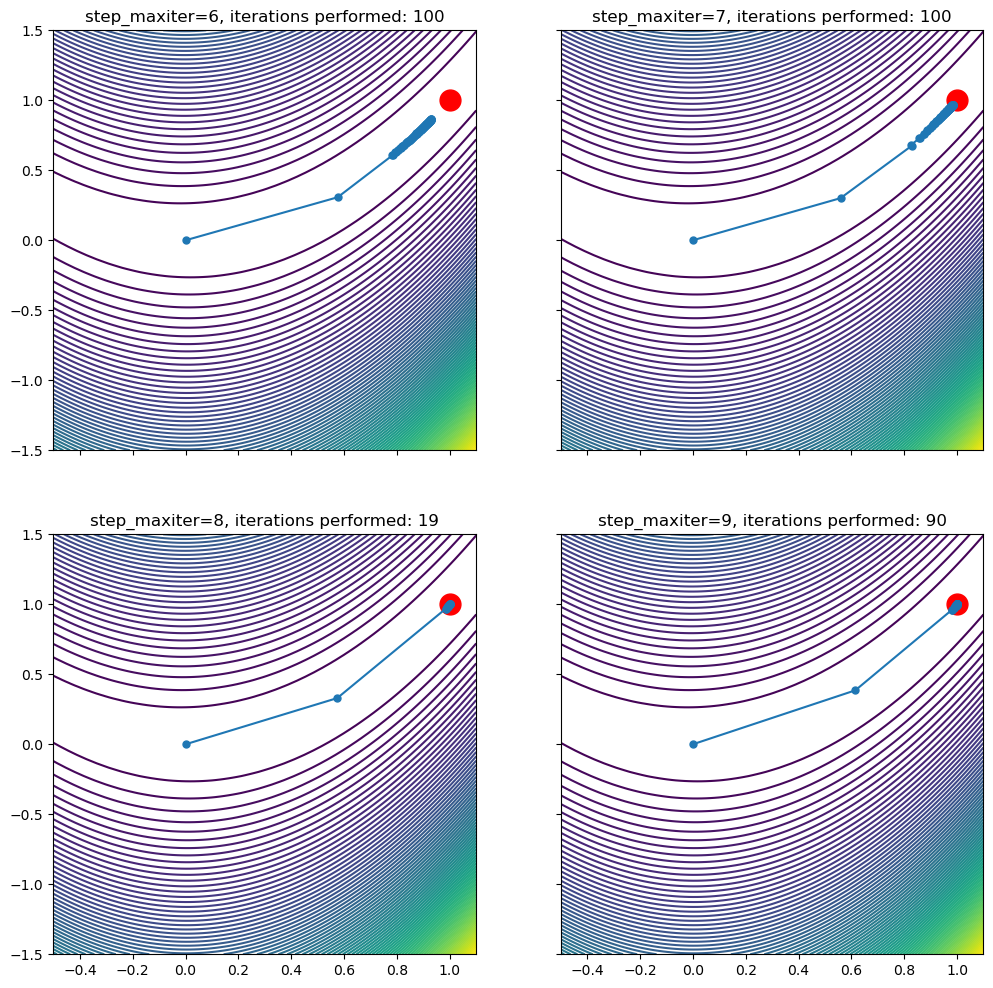

In [32]:
x = np.linspace(-0.5, 1.1, 100)
y = np.linspace(-1.5, 1.5, 100)

x, y = np.meshgrid(x, y)
z = rosenbrock(np.array((x, y)))

fig, axs = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)

k = 6
for i in range(2):
    for j in range(2):
        xy = values[k][0]

        axs[i, j].set_title(f"step_maxiter={k}, iterations performed: {values[k][1]}")
        axs[i, j].contour(x, y, z, 100)
        axs[i, j].plot(1, 1, marker='o', markersize=15, color ='r')

        axs[i, j].plot(xy[:, 0], xy[:, 1], marker='o', markersize=5)
        k += 1

plt.show()

In [164]:
minimize_grd = ThreeStepIterative(step_1=DFP(), step_2=GradientDescent())
minimize_grd.history['x'] = []
min_w_g = minimize_grd(
    [1.5, 1],
    ackley,
    ackley_grad,
    maxiter=1000,
    eps=1e-6,
    step_maxiter=lambda ic: 1,
    record=True,
    method='brent'
)
minimize_grd.history['x'].append(min_w_g.x)
min_w_g

MinimizeResult(x=array([-2.77414422e-16, -1.84942434e-16]), success=True, nit=3)

In [165]:
minimize_fd = ThreeStepIterative(step_1=DFP(), step_2=GradientDescent())
minimize_fd.history['x'] = []
min_wo_g = minimize_fd(
    [1.5, 1],
    ackley,
    None,
    maxiter=100,
    eps=1e-6,
    step_maxiter=lambda ic: 1,
    record=True,
    method='brent'
)
minimize_fd.history['x'].append(min_wo_g.x)
min_wo_g

MinimizeResult(x=array([-3.00600603e-09, -2.08195224e-09]), success=True, nit=3)

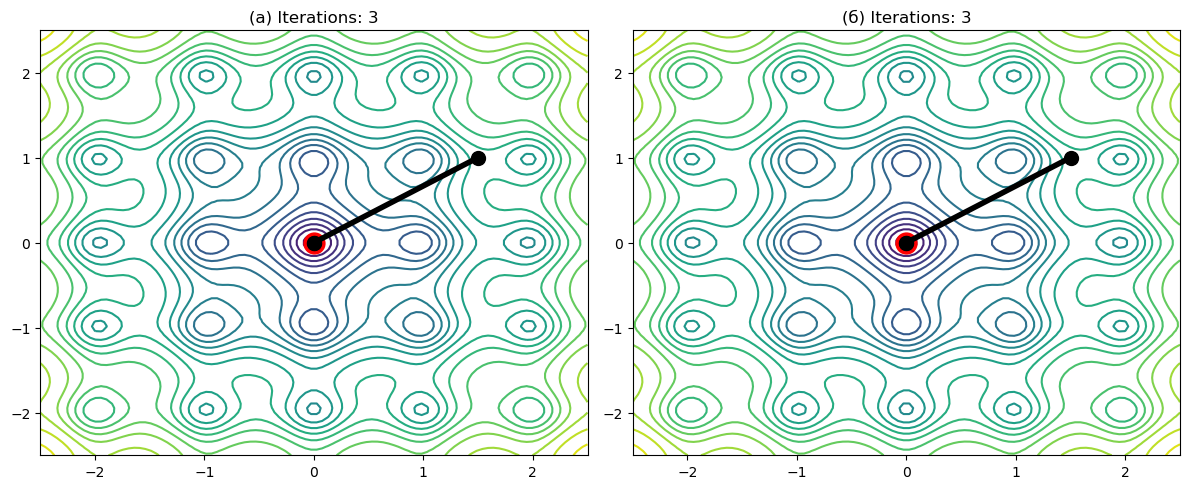

In [166]:
x = np.linspace(-2.5, 2.5, 100)
y = np.linspace(-2.5, 2.5, 100)

x, y = np.meshgrid(x, y)
z = ackley(np.array((x, y)))

xy_grd = np.asarray(minimize_grd.history['x'])
xy_fd = np.asarray(minimize_fd.history['x'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.set_title(f"(a) Iterations: {min_w_g.nit}")
ax1.contour(x, y, z, 20)
ax1.plot(0, 0, marker='o', markersize=15, color ='r')
ax1.plot(xy_grd[:, 0], xy_grd[:, 1], marker='o', markersize=10, color='black', lw=4)

ax2.set_title(f"(б) Iterations: {min_wo_g.nit}")
ax2.contour(x, y, z, 20)
ax2.plot(0, 0, marker='o', markersize=15, color ='r')
ax2.plot(xy_fd[:, 0], xy_fd[:, 1], marker='o', markersize=10, color='black', lw=4)

plt.show()

### Compare

In [253]:
cols = ['Broyden', 'DFP', 'BFGS', 'Newton', 'Three-step']
results = {}

In [254]:
dfp = DFP()
min_dfp = dfp(
    [0, 0],
    rosenbrock,
    None,
    maxiter=100,
    eps=1e-6
)
min_dfp

MinimizeResult(x=array([0.999997  , 0.99999399]), success=True, nit=28)

In [255]:
broyden = Broyden()
min_broyden = broyden(
    [0, 0],
    rosenbrock,
    None,
    maxiter=100,
    eps=1e-6
)
min_broyden

MinimizeResult(x=array([0.999997  , 0.99999399]), success=True, nit=26)

In [256]:
bfgs = BFGS()
min_bfgs = bfgs(
    [0, 0],
    rosenbrock,
    None,
    maxiter=100,
    eps=1e-6
)
min_bfgs

MinimizeResult(x=array([0.999997  , 0.99999399]), success=True, nit=22)

In [257]:
nwt = Newton()
min_nwt = nwt(
    [0, 0],
    rosenbrock,
    None,
    ddf=rosenbrock_hess,
    maxiter=100,
    eps=1e-6
)
min_nwt

MinimizeResult(x=array([0.999997  , 0.99999399]), success=True, nit=5)

In [258]:
tsi = ThreeStepIterative(step_1=DFP(), step_2=GradientDescent())
min_tsi = tsi(
    [0, 0],
    rosenbrock,
    None,
    maxiter=100,
    eps=1e-6,
    step_maxiter=lambda ic: 2,
    record=False,
    method='brent'
)
min_tsi

MinimizeResult(x=array([0.99999998, 0.99999998]), success=True, nit=15)

In [259]:
results['rosenbrock'] = [min_broyden.nit, min_dfp.nit, min_bfgs.nit, min_nwt.nit, min_tsi.nit]

In [260]:
dfp = DFP()
min_dfp = dfp(
    [1, 1],
    himmelblau,
    None,
    maxiter=100,
    eps=1e-6
)
min_dfp

MinimizeResult(x=array([3.00000068, 1.99999668]), success=True, nit=9)

In [261]:
broyden = Broyden()
min_broyden = broyden(
    [1, 1],
    himmelblau,
    None,
    maxiter=100,
    eps=1e-6
)
min_broyden

MinimizeResult(x=array([2.99998317, 1.99995513]), success=True, nit=8)

In [262]:
bfgs = BFGS()
min_bfgs = bfgs(
    [1, 1],
    himmelblau,
    None,
    maxiter=100,
    eps=1e-6
)
min_bfgs

MinimizeResult(x=array([2.99994799, 1.99997077]), success=True, nit=8)

In [263]:
nwt = Newton()
min_nwt = nwt(
    [1, 1],
    himmelblau,
    None,
    ddf=himmelblau_hess,
    maxiter=100,
    eps=1e-6
)
min_nwt

MinimizeResult(x=array([-3.77931026, -3.283186  ]), success=True, nit=9)

In [264]:
tsi = ThreeStepIterative(step_1=DFP(), step_2=GradientDescent())
min_tsi = tsi(
    [1, 1],
    himmelblau,
    None,
    maxiter=100,
    eps=1e-6,
    step_maxiter=lambda ic: 1,
    record=False,
    method='brent'
)
min_tsi

MinimizeResult(x=array([2.99999987, 2.00000024]), success=True, nit=14)

In [265]:
results['himmelblau'] = [min_broyden.nit, min_dfp.nit, min_bfgs.nit, min_nwt.nit, min_tsi.nit]

In [266]:
dfp = DFP()
min_dfp = dfp(
    [1.5, 1.5],
    ackley,
    None,
    maxiter=100,
    eps=1e-6
)
min_dfp

MinimizeResult(x=array([-1.27129019e-05, -1.27129019e-05]), success=True, nit=8)

In [267]:
broyden = Broyden()
min_broyden = broyden(
    [1.5, 1.5],
    ackley,
    None,
    maxiter=100,
    eps=1e-6
)
min_broyden

MinimizeResult(x=array([-1.26874577e-05, -1.26874577e-05]), success=True, nit=8)

In [268]:
bfgs = BFGS()
min_bfgs = bfgs(
    [1.5, 1.5],
    ackley,
    None,
    maxiter=100,
    eps=1e-6
)
min_bfgs

MinimizeResult(x=array([-1.27129019e-05, -1.27129019e-05]), success=True, nit=8)

In [269]:
tsi = ThreeStepIterative(step_1=DFP(), step_2=GradientDescent())
min_tsi = tsi(
    [1.5, 1.5],
    ackley,
    None,
    maxiter=100,
    eps=1e-6,
    step_maxiter=lambda ic: 1,
    record=False,
    method='brent'
)
min_tsi

MinimizeResult(x=array([7.07048352e-12, 7.07048352e-12]), success=True, nit=3)

In [270]:
results['ackley'] = [min_broyden.nit, min_dfp.nit, min_bfgs.nit, 'n/a', min_tsi.nit]

In [271]:
results

{'rosenbrock': [26, 28, 22, 5, 15],
 'himmelblau': [8, 9, 8, 9, 14],
 'ackley': [8, 8, 8, 'n/a', 3]}

In [272]:
df = pd.DataFrame.from_dict(results, orient='index', columns=cols)
df

Broyden  DFP  BFGS Newton  Three-step
rosenbrock       26   28    22      5          15
himmelblau        8    9     8      9          14
ackley            8    8     8    n/a           3

In [146]:
minimizer = ThreeStepIterative(step_1=Broyden(), step_2=GradientDescent())
min_broyden = minimizer(
    [0, 0],
    rosenbrock,
    None,
    maxiter=100,
    eps=1e-6,
    step_maxiter=lambda ic: 2,
    record=True,
    method='brent'
)
min_broyden

MinimizeResult(x=array([1.00000044, 1.00000087]), success=True, nit=13)

In [147]:
minimizer.history['x']

[array([0., 0.]),
 array([0.30686215, 0.07533974]),
 array([0.47496613, 0.20022918]),
 array([0.67466986, 0.43593576]),
 array([0.84147408, 0.69555101]),
 array([0.95122071, 0.89725855]),
 array([0.97107601, 0.943716  ]),
 array([1.00192065, 1.00434948]),
 array([1.0012343 , 1.00245387]),
 array([1.00009898, 1.00022483]),
 array([1.00006335, 1.00012589]),
 array([1.00000041, 1.00000106])]

In [150]:
df_dict = dict(zip(range(len(minimizer.history['x'])), minimizer.history['x']))
df = pd.DataFrame.from_dict(df_dict, orient='index', columns=['x', 'y'])
df

x         y
0   0.000000  0.000000
1   0.306862  0.075340
2   0.474966  0.200229
3   0.674670  0.435936
4   0.841474  0.695551
5   0.951221  0.897259
6   0.971076  0.943716
7   1.001921  1.004349
8   1.001234  1.002454
9   1.000099  1.000225
10  1.000063  1.000126
11  1.000000  1.000001

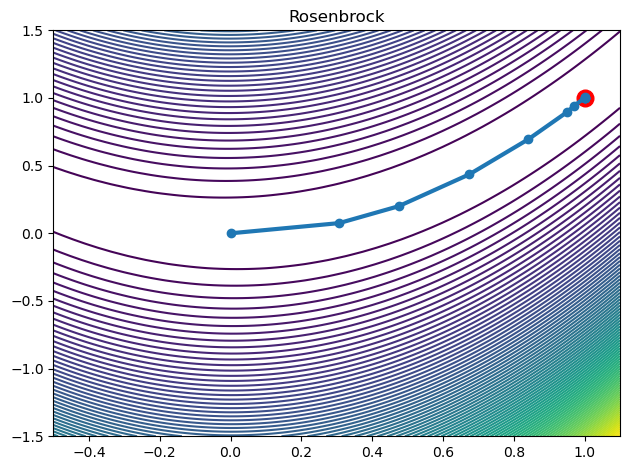

In [161]:
x = np.linspace(-0.5, 1.1, 100)
y = np.linspace(-1.5, 1.5, 100)

x, y = np.meshgrid(x, y)
z = rosenbrock(np.array((x, y)))

xy = np.asarray(minimizer.history['x'])

fig, ax = plt.subplots( nrows=1, ncols=1 )

ax.set_title("Rosenbrock")
ax.contour(x, y, z, 100)
ax.plot(1, 1, marker='o', markersize=12, color ='r')

ax.plot(xy[:, 0], xy[:, 1], marker='o', markersize=6, lw=3)

plt.show()